![](img/workshop-banner.png)

# Module 3: Preprocessing, `sklearn` Pipeline, `sklearn` ColumnTrasnsformer

Instructor: Varada Kolhatkar

## Imports, LOs

### Imports

In [1]:
import sys
import time

import matplotlib.pyplot as plt

import sys
sys.path.append("code/.")
from plotting_functions import *

%matplotlib inline
import numpy as np
import pandas as pd

from IPython.display import display

### Learning outcomes

From this lecture, you will be able to 

- explain motivation for preprocessing in supervised machine learning;
- identify when to implement feature transformations such as imputation, scaling, and one-hot encoding in a machine learning model development pipeline; 
- use `sklearn` transformers for applying feature transformations on your dataset;
- discuss golden rule in the context of feature transformations;
- use `sklearn.pipeline.Pipeline` and `sklearn.pipeline.make_pipeline` to build a preliminary machine learning pipeline. 
- use `ColumnTransformer` to build all our transformations together into one object and use it with `sklearn` pipelines;
- define `ColumnTransformer` where transformers contain more than one steps;

<br><br>

## Introduction and motivation

### Machine learning workflow 

A typical workflow of a supervised machine learning systems.  

![](img/ml-workflow.png)

<!-- <img src="img/ml-workflow.png" height="800" width="800">  -->

We will build machine learning pipelines in this course, focusing on some of the steps above. 

- So far we have seen
    - ML fundamentals (train-validation-test split, cross-validation, the fundamental tradeoff, the golden rule)
- We are assuming that you are familiar with some basic ML models
    - decision trees, $k$-NNs, logistic regression    
- Are we ready to do machine learning on real-world datasets?
    - Very often real-world datasets need preprocessing before we use them to build ML models. 

We will gain hands-on experience in constructing preprocessing pipelines using sklearn by applying them to various datasets. Let's start simple. 

## Example 1: Predicting whether a text message is spam or not spam

[Kaggle’s SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset). 

In [2]:
sms_df = pd.read_csv("data/spam.csv", encoding="latin-1")
sms_df = sms_df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})
sms_df.head()

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data splitting

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score

train_df, test_df = train_test_split(sms_df, test_size=0.2, random_state=123)
train_df.head()

,target,sms
385,ham,It took Mr owl 3 licks
4003,ham,Well there's a pattern emerging of my friends ...
1283,ham,Yes i thought so. Thanks.
2327,spam,URGENT! Your mobile number *************** WON...
1103,ham,Aiyah sorry lor... I watch tv watch until i fo...


In [4]:
X_train, y_train = train_df['sms'], train_df['target']
X_test, y_test = test_df['sms'], test_df['target']

### Preliminary EDA

### Baseline 

In [5]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
cross_val_score(dummy, X_train, y_train)

array([0.86210762, 0.86210762, 0.8630752 , 0.86195286, 0.86195286])

Good to know! 

### Logistic regression

Let's try logistic regression. 

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
lr = LogisticRegression()
# lr.fit(X_train, y_train)

- We need numerically encoded input to pass to a machine learning model. 
- How can we encode it so that we can pass it to a machine learning algorithm?
- We do not have a fixed number of categories here. 
- How can we encode or represent raw text data into fixed number of features so that we can learn some useful patterns from it?  
- This is a well studied problem in the field of Natural Language Processing (NLP), which is concerned with giving computers the ability to understand written and spoken language. 
- Some popular representations of raw text include: 
    - **Bag of words** 
    - TF-IDF
    - Embedding representations 

### Bag of words (BOW) representation

- One of the most popular representation of raw text 
- Ignores the syntax and word order
- It has two components: 
    - The vocabulary (all unique words in all documents) 
    - A value indicating either the presence or absence or the count of each word in the document. 
        
<center>
<img src='./img/bag-of-words.png' width="600">
</center>

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

### Extracting BOW features using `scikit-learn`
- `CountVectorizer`
    - Converts a collection of text documents to a matrix of word counts.  
    - Each row represents a "document" (e.g., a text message in our example). 
    - Each column represents a word in the vocabulary (the set of unique words) in the training data. 
    - Each cell represents how often the word occurs in the document.       

```{note}
In the Natural Language Processing (NLP) community text data  is referred to as a **corpus** (plural: corpora). ```   

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_train_bow = vec.fit_transform(X_train)
bow_df = pd.DataFrame(
    X_train_bow.toarray(), columns=vec.get_feature_names_out(), index=X_train
)
bow_df

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,ì_,ì¼1,ìï,û_,û_thanks,ûªm,ûªt,ûªve,ûò,ûówell
sms,,,,,,,,,,,,,,,,,,,,,
It took Mr owl 3 licks,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Well there's a pattern emerging of my friends telling me to drive up and come smoke with them and then telling me that I'm a weed fiend/make them smoke too much/impede their doing other things so you see how I'm hesitant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Yes i thought so. Thanks.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"URGENT! Your mobile number *************** WON a å£2000 Bonus Caller prize on 10/06/03! This is the 2nd attempt to reach you! Call 09066368753 ASAP! Box 97N7QP, 150ppm",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Aiyah sorry lor... I watch tv watch until i forgot 2 check my phone.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
I accidentally brought em home in the box,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"Aight I've been set free, think you could text me blake's address? It occurs to me I'm not quite as sure what I'm doing as I thought I was",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Is it ok if I stay the night here? Xavier has a sleeping bag and I'm getting tired,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`CountVectorizer` has encoded the text data which can be passed to logistic regression. Let's try that.

In [9]:
lr_spam = LogisticRegression()
lr_spam.fit(X_train_bow, y_train)
lr_spam.score(X_train_bow, y_train)

0.9973076060130133

This is training score. What about test score? We need to apply the same transformation on the test data as well. 

In [10]:
X_test_bow = vec.transform(X_test)
lr_spam.score(X_test_bow, y_test)

0.9829596412556054

### Sparse matrices 

The bag-of-words encoded data is stored as a sparse matrix.

In [11]:
X_train_bow

<4457x7682 sparse matrix of type '<class 'numpy.int64'>'
	with 59329 stored elements in Compressed Sparse Row format>

- Most words do not appear in a given document.
- We get massive computational savings if we only store the nonzero elements.
- There is a bit of overhead, because we also need to store the locations:
    - e.g. "location (3,27): 1".
    
- However, if the fraction of nonzero is small, this is a huge win.

In [12]:
print("The total number of elements: ", np.prod(X_train_bow.shape))
print("The number of non-zero elements: ", X_train_bow.nnz)
print(
    "Proportion of non-zero elements: %0.4f" % (X_train_bow.nnz / np.prod(X_train_bow.shape))
)
print(
    "The value at cell 3,%d is: %d"
    % (vec.vocabulary_["jackpot"], X_train_bow[3, vec.vocabulary_["jackpot"]])
)

The total number of elements:  34238674
The number of non-zero elements:  59329
Proportion of non-zero elements: 0.0017
The value at cell 3,3778 is: 0


### Important hyperparameters of `CountVectorizer` 

- `binary`
    - whether to use absence/presence feature values or counts
- `max_features`
    - only consider top `max_features` ordered by frequency in the corpus
- `max_df`
    - ignore features which occur in more than `max_df` documents 
- `min_df` 
    - ignore features which occur in less than `min_df` documents 
- `ngram_range`
    - consider word sequences in the given range 

### `sklearn` estimators vs. transformers

In order to fit a model on this data set we carried out two steps
- Transform the data using `CountVectorizer`. 
- Fit logistic regression on the transformed data. 

In `sklearn` terminology, models such as `LogisticRegression` or `KNeighborsClassifier` are **estimators** whereas `CountVectorizer` are **transformers**. 



### `sklearn` API summary: estimators

Suppose `model` is a classification or regression model. 

```
model.fit(X_train, y_train)
X_train_predictions = model.predict(X_train)
X_test_predictions = model.predict(X_test)
```    

### `sklearn` API summary: transformers

Suppose `transformer` is a transformer used to change the input representation, for example, to tackle missing values or to scales numeric features.

```
transformer.fit(X_train, [y_train])
X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)
```  

- You can pass `y_train` in `fit` but it's usually ignored. It allows you to pass it just to be consistent with usual usage of `sklearn`'s `fit` method.   
- You can also carry out fitting and transforming in one call using `fit_transform`. But be mindful to use it only on the train split and **not** on the test split. 

### Cross-validation on the transformed data

- In the previous module we told you that it's always a good practice to carry out cross-validation to get reliable estimate of model performance. 
- Is it alright if we carry out cross validation on the already transformed data as shown below? 
- Do you see any problem here? 

In [13]:
cross_val_score(lr_spam, X_train_bow, y_train)

array([0.98430493, 0.98766816, 0.97979798, 0.97643098, 0.98092031])

<br><br><br><br><br><br>

- Are we applying `fit_transform` on train portion and `transform` on validation portion in each fold of cross validation? 
    - Here you are allowing information from the validation set to **leak** into the training step.

- You need to apply the **SAME** preprocessing steps to train/validation.
- With many different transformations and cross validation the code gets unwieldy very quickly. 
- Likely to make mistakes and "leak" information.

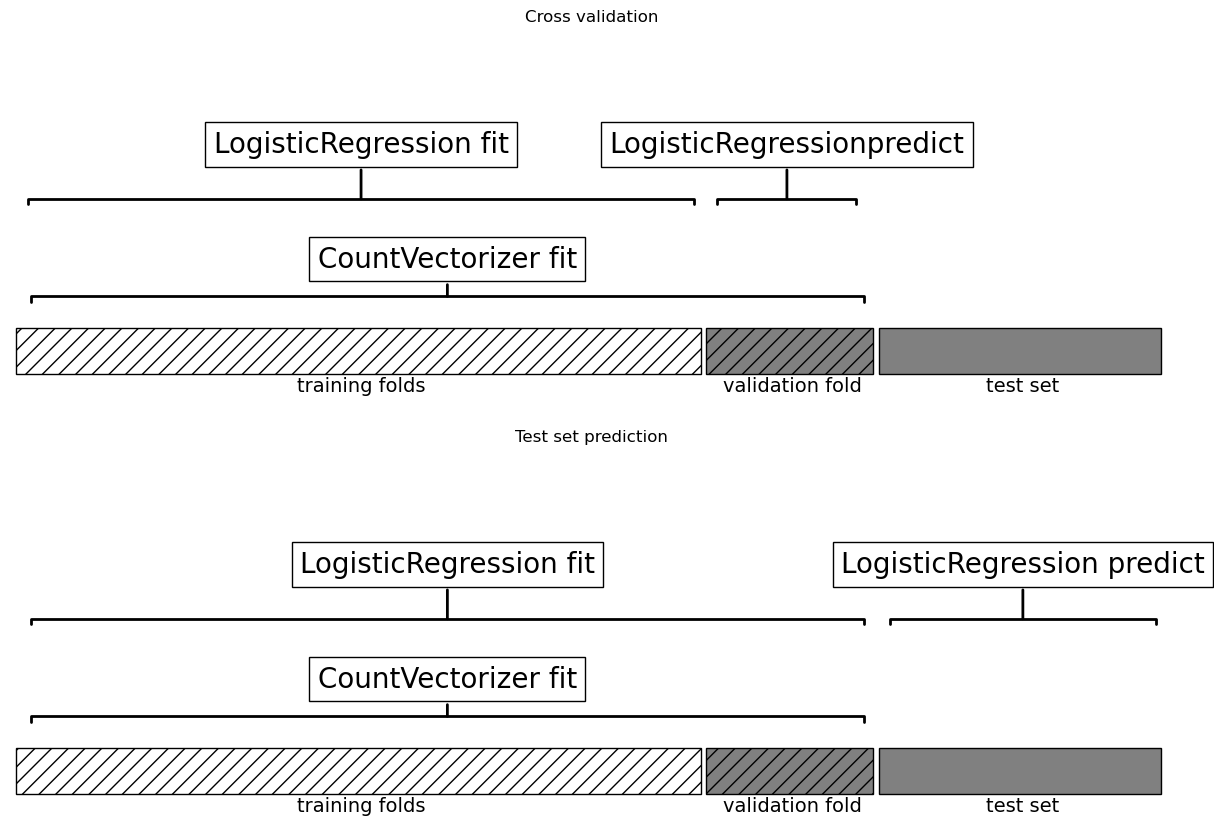

In [14]:
plot_improper_processing("LogisticRegression", 'CountVectorizer')

- In these examples our test accuracies look fine, but our methodology is flawed.
- Implications can be significant in practice!

### Pipelines

Can we do this in a more elegant and organized way?

- YES!! Using [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- [`scikit-learn Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) allows you to define a "pipeline" of transformers with a final estimator.

Let's combine the preprocessing and model with pipeline

In [15]:
### Simple example of a pipeline
from sklearn.pipeline import make_pipeline

lr_spam_pipe = make_pipeline(CountVectorizer(), LogisticRegression())
lr_spam_pipe.fit(X_train, y_train) # note that we are now passing the original data. 

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression())])

In [16]:
cross_val_score(lr_spam_pipe, X_train, y_train) # no leakage of information 

array([0.98430493, 0.98766816, 0.97979798, 0.97643098, 0.98092031])

- Using a `Pipeline` takes care of applying the `fit_transform` on the train portion and only `transform` on the validation portion in each fold.   

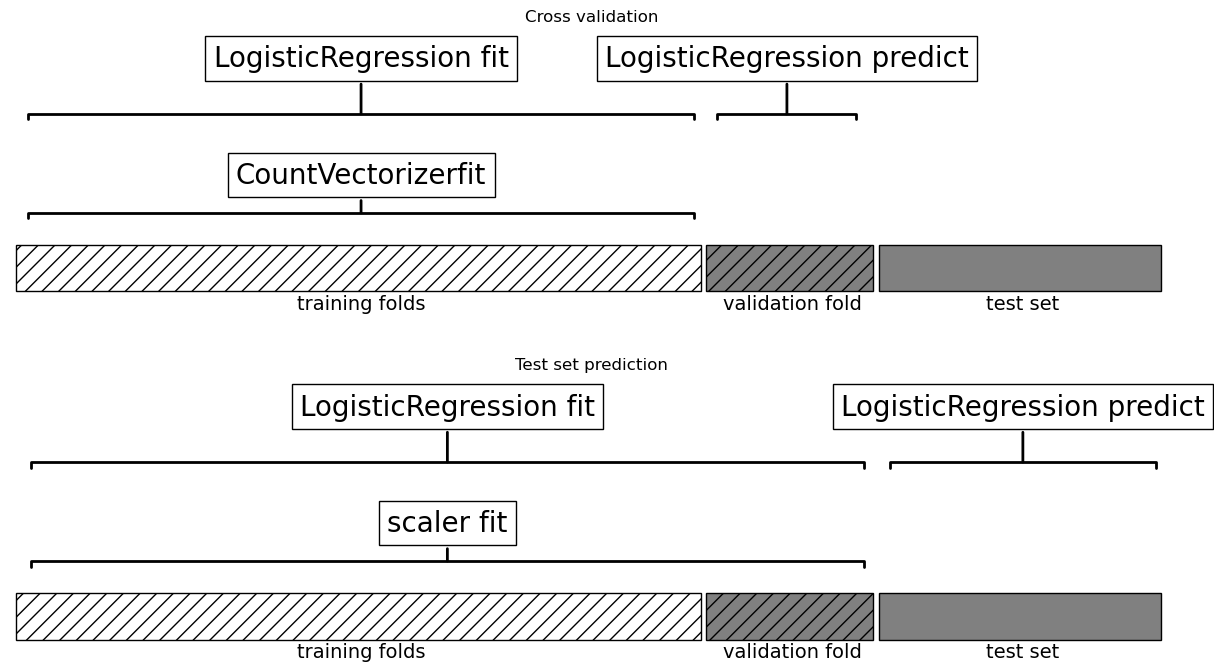

In [17]:
plot_proper_processing("LogisticRegression", 'CountVectorizer')

### Visualizing the vocabulary 

- How can we access different steps in a pipeline? 
- Let's access vocabulary of `CountVectorizer`

In [18]:
lr_spam_pipe.named_steps

{'countvectorizer': CountVectorizer(),
 'logisticregression': LogisticRegression()}

In [19]:
vocab = lr_spam_pipe['countvectorizer'].get_feature_names_out()
len(vocab)

7682

In [20]:
vocab[0:10]

array(['00', '000', '000pes', '008704050406', '0089', '0121',
       '01223585236', '01223585334', '0125698789', '02'], dtype=object)

In [21]:
vocab[500:510]

array(['440', '4403ldnw1a7rw18', '44345', '447797706009', '447801259231',
       '448712404000', '449050000301', '449071512431', '45', '450'],
      dtype=object)

In [22]:
vocab[1800:1810]

array(['chinese', 'chinky', 'chinnu', 'chiong', 'chip', 'chit', 'chk',
       'chloe', 'chocolate', 'choice'], dtype=object)

In [23]:
vocab[0::100]

array(['00', '08712101358', '09061701851', '12mths', '2find', '440',
       '69911', '86888', 'accommodationvouchers', 'aint', 'answerin',
       'asa', 'b4190604', 'become', 'bleak', 'brainy', 'buzz', 'causing',
       'chinese', 'colleagues', 'converter', 'cttargg', 'deduct',
       'different', 'donyt', 'eastenders', 'entitled', 'expected',
       'feellikw', 'flowing', 'frnt', 'george', 'gower', 'hand', 'here',
       'hotmix', 'ill', 'interesting', 'jaykwon', 'kath', 'lamp', 'lido',
       'loosing', 'madoke', 'mcr', 'miserable', 'movie', 'nattil',
       'nooooooo', 'okies', 'overa', 'payments', 'placed', 'postal',
       'problem', 'quoting', 'recovery', 'restocked', 'runs',
       'scrumptious', 'shaking', 'signing', 'sms', 'sparkling',
       'statements', 'submitted', 'sweater', 'telly', 'those', 'tonite',
       'tuesday', 'unrecognized', 'very', 'wallpaper', 'wewa', 'women',
       'yay'], dtype=object)

<br><br>

## ❓❓ Questions for you 

### Exercise 3.1 

**Select all of the following statements which are TRUE.**

- (A) As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
- (B) Suppose you are encoding text data using `CountVectorizer`. If you encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
- (C) In the code below, inside `cross_validate`, each fold might have slightly different number of features (columns) in the fold.

```
pipe = (CountVectorizer(), SVC())
cross_validate(pipe, X_train, y_train)
```

### Discussion questions

- What's the problem with calling `fit_transform` in the context of `CountVectorizer`?
- Do we need to scale after applying bag-of-words representation? 

<br><br><br><br>

## Example 2: Predicting whether a user likes a song or not 

[Spotify dataset from Kaggle](https://www.kaggle.com/geomack/spotifyclassification/download)

### Read the data CSV and data splitting 

In [24]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)
spotify_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


In [25]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(spotify_df, test_size=0.20, random_state=123)

X_train, y_train = (
    train_df.drop(columns=["song_title", "artist", "target"]),
    train_df["target"],
)
X_test, y_test = (
    test_df.drop(columns=["song_title", "artist", "target"]),
    test_df["target"],
)

In [26]:
train_df['target'].value_counts()

target
1    819
0    794
Name: count, dtype: int64

## Exploratory data analysis

In [27]:
train_df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1613 entries, 1505 to 1534
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      1613 non-null   float64
 1   danceability      1613 non-null   float64
 2   duration_ms       1613 non-null   int64  
 3   energy            1613 non-null   float64
 4   instrumentalness  1613 non-null   float64
 5   key               1613 non-null   int64  
 6   liveness          1613 non-null   float64
 7   loudness          1613 non-null   float64
 8   mode              1613 non-null   int64  
 9   speechiness       1613 non-null   float64
 10  tempo             1613 non-null   float64
 11  time_signature    1613 non-null   float64
 12  valence           1613 non-null   float64
 13  target            1613 non-null   int64  
 14  song_title        1613 non-null   object 
 15  artist            1613 non-null   object 
dtypes: float64(10), int64(4), object(2)
memory u

### Baseline 

In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, cross_val_score

dummy = DummyClassifier(strategy="most_frequent")
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.508


,fit_time,score_time,test_score,train_score
0,0.000427,0.000249,0.507740,0.507752
1,0.000249,0.000190,0.507740,0.507752
2,0.000229,0.000187,0.507740,0.507752
3,0.000222,0.000352,0.506211,0.508133
4,0.000353,0.000208,0.509317,0.507359


### Try different models

- In practice set 1 you used `DecisionTreeClassifier` to predict whether the user would like a particular song or not. 
- Can we use $k$-NN classifier for this task? 
- Intuition: To predict whether the user likes a particular song or not (query point) 
   - find the songs that are closest to the query point
   - let them vote on the target
   - take the majority vote as the target for the query point   

Let's try K-nearest neighbours classifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
scores = cross_validate(knn, X_train, y_train, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(scores["test_score"])))
pd.DataFrame(scores)

Mean validation score 0.546


,fit_time,score_time,test_score,train_score
0,0.001249,0.003765,0.563467,0.717829
1,0.001201,0.003531,0.535604,0.721705
2,0.001094,0.003576,0.529412,0.708527
3,0.001076,0.004072,0.537267,0.721921
4,0.001205,0.003539,0.562112,0.711077


#### Seems like we are not improving over the baseline. What could be the reason? 

In [31]:
train_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
1505,0.00477,0.585,214740,0.614,0.000155,10,0.0762,-5.594,0,0.0370,114.059,4.0,0.2730,0,Cool for the Summer,Demi Lovato
813,0.11400,0.665,216728,0.513,0.303000,0,0.1220,-7.314,1,0.3310,100.344,3.0,0.0373,1,Damn Son Where'd You Find This? (feat. Kelly H...,Markus Maximus
615,0.03020,0.798,216585,0.481,0.000000,7,0.1280,-10.488,1,0.3140,127.136,4.0,0.6400,1,Trill Hoe,Western Tink
319,0.10600,0.912,194040,0.317,0.000208,6,0.0723,-12.719,0,0.0378,99.346,4.0,0.9490,1,Who Is He (And What Is He to You?),Bill Withers
320,0.02110,0.697,236456,0.905,0.893000,6,0.1190,-7.787,0,0.0339,119.977,4.0,0.3110,1,Acamar,Frankey


The scales of features are different! 

In [32]:
two_songs = X_train.sample(2, random_state=42)
two_songs

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
842,0.229000,0.494,147893,0.666,0.000057,9,0.0469,-9.743,0,0.0351,140.832,4.0,0.704
654,0.000289,0.771,227143,0.949,0.602000,8,0.5950,-4.712,1,0.1750,111.959,4.0,0.372


In [33]:
from sklearn.metrics.pairwise import euclidean_distances

euclidean_distances(two_songs)

array([[    0.        , 79250.00543825],
       [79250.00543825,     0.        ]])

Let's consider only two features: `duration_ms` and `tempo`.

In [34]:
two_songs_subset = two_songs[["duration_ms", "tempo"]]
two_songs_subset

,duration_ms,tempo
842,147893,140.832
654,227143,111.959


In [35]:
euclidean_distances(two_songs_subset)

array([[    0.        , 79250.00525962],
       [79250.00525962,     0.        ]])

Do you see any problem? 

- The distance is completely dominated by the the features with larger values
- The features with smaller values are being ignored. 
- Does it matter? 
    - Yes! Scale is based on how data was collected. 
    - Features on a smaller scale can be highly informative and there is no good reason to ignore them.
    - We want our model to be robust and not sensitive to the scale. 
- Was this a problem for decision trees?

### Scaling using `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

- We'll use `scikit-learn`'s [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which is a `transformer`.   

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # create feature trasformer object
scaler.fit(X_train)  # fitting the transformer on the train split
X_train_scaled = scaler.transform(X_train)  # transforming the train split
X_test_scaled = scaler.transform(X_test)  # transforming the test split

In [37]:
# from sklearn.preprocessing import StandardScaler

# scaler =   # create feature trasformer object
# scaler.fit()  # fitting the transformer on the train split
# X_train_scaled =  # transforming the train split
# X_test_scaled =  # transforming the test split

In [38]:
X_train # original X_train

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1505,0.004770,0.585,214740,0.614,0.000155,10,0.0762,-5.594,0,0.0370,114.059,4.0,0.2730
813,0.114000,0.665,216728,0.513,0.303000,0,0.1220,-7.314,1,0.3310,100.344,3.0,0.0373
615,0.030200,0.798,216585,0.481,0.000000,7,0.1280,-10.488,1,0.3140,127.136,4.0,0.6400
319,0.106000,0.912,194040,0.317,0.000208,6,0.0723,-12.719,0,0.0378,99.346,4.0,0.9490
320,0.021100,0.697,236456,0.905,0.893000,6,0.1190,-7.787,0,0.0339,119.977,4.0,0.3110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.001060,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.2110
1346,0.000021,0.535,203500,0.974,0.000149,10,0.2630,-3.566,0,0.1720,116.956,4.0,0.4310
1406,0.503000,0.410,256333,0.648,0.000000,7,0.2190,-4.469,1,0.0362,60.391,4.0,0.3420
1389,0.705000,0.894,222307,0.161,0.003300,4,0.3120,-14.311,1,0.0880,104.968,4.0,0.8180


Let's examine transformed value of the energy feature in the first row. 

In [39]:
X_train['energy'].iloc[0]

0.614

In [40]:
(X_train['energy'].iloc[0] - np.mean(X_train['energy']))/ X_train['energy'].std()

-0.3180174485124284

In [41]:
pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index).head().round(3)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
1505,-0.698,-0.195,-0.399,-0.318,-0.492,1.276,-0.738,0.396,-1.281,-0.618,-0.294,0.139,-0.908
813,-0.276,0.296,-0.374,-0.796,0.598,-1.487,-0.439,-0.052,0.781,2.728,-0.803,-3.781,-1.861
615,-0.600,1.111,-0.376,-0.947,-0.493,0.447,-0.400,-0.879,0.781,2.535,0.191,0.139,0.576
319,-0.307,1.809,-0.654,-1.722,-0.492,0.170,-0.763,-1.461,-1.281,-0.609,-0.840,0.139,1.825
320,-0.635,0.492,-0.131,1.057,2.723,0.170,-0.458,-0.176,-1.281,-0.653,-0.074,0.139,-0.754


In [42]:
knn_unscaled = KNeighborsClassifier() 
knn_unscaled.fit(X_train, y_train) # fitting on unscaled data
print("Train score: %0.3f" % (knn_unscaled.score(X_train, y_train)))
print("Test score: %0.3f" % (knn_unscaled.score(X_test, y_test)))

Train score: 0.726
Test score: 0.552


In [43]:
knn_scaled = KNeighborsClassifier()
knn_scaled.fit(X_train_scaled, y_train) # fitting on scaled data
print("Train score: %0.3f" % (knn_scaled.score(X_train_scaled, y_train)))
print("Test score: %0.3f" % (knn_scaled.score(X_test_scaled, y_test)))

Train score: 0.798
Test score: 0.686


- The scores with scaled data are better compared to the unscaled data in case of $k$-NNs.
- I am not carrying out cross-validation here for a reason that we'll look into soon. 
- Note that I am a bit sloppy here and using the test set several times for teaching purposes. But when you build an ML pipeline, please do assessment on the test set only once.  

What about logistic regression? Do we need to scale numeric features? 

In [44]:
from sklearn.linear_model import LogisticRegression

lr_unscaled = LogisticRegression()
lr_unscaled.fit(X_train, y_train)

print("Train score: %0.3f" % (lr_unscaled.score(X_train, y_train)))
print("Test score: %0.3f" % (lr_unscaled.score(X_test, y_test)))

Train score: 0.508
Test score: 0.498


In [45]:
lr_scaled = LogisticRegression()
lr_scaled.fit(X_train_scaled, y_train)

print("Train score: %0.3f" % (lr_scaled.score(X_train_scaled, y_train)))
print("Test score: %0.3f" % (lr_scaled.score(X_test_scaled, y_test)))

Train score: 0.661
Test score: 0.671


In `sklearn` logistic regression by default uses regularization. So it's important to apply scaling before training a model. 

### (Optional) What are other approaches for scaling? 
- [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html): Transform each feature to a desired range
- [RobustScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html): Scale features using median and quantiles. Robust to outliers. 
- [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html): Works on rows rather than columns. Normalize examples individually to unit norm. 
- What would happen when you apply `StandardScaler` to sparse data?
    - [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html): A scaler that scales each feature by its maximum absolute value. 

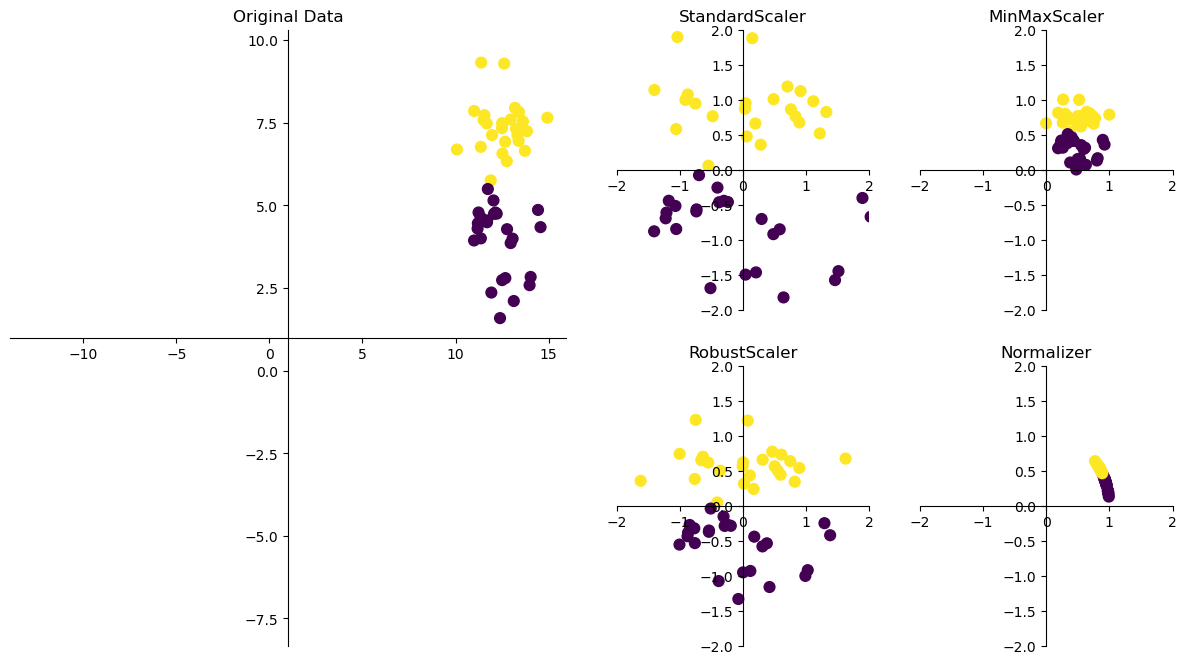

In [46]:
plot_scaling()

<br><br>

Let's carefully examine all the features in our data. 

In [47]:
train_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
1505,0.00477,0.585,214740,0.614,0.000155,10,0.0762,-5.594,0,0.0370,114.059,4.0,0.2730,0,Cool for the Summer,Demi Lovato
813,0.11400,0.665,216728,0.513,0.303000,0,0.1220,-7.314,1,0.3310,100.344,3.0,0.0373,1,Damn Son Where'd You Find This? (feat. Kelly H...,Markus Maximus
615,0.03020,0.798,216585,0.481,0.000000,7,0.1280,-10.488,1,0.3140,127.136,4.0,0.6400,1,Trill Hoe,Western Tink
319,0.10600,0.912,194040,0.317,0.000208,6,0.0723,-12.719,0,0.0378,99.346,4.0,0.9490,1,Who Is He (And What Is He to You?),Bill Withers
320,0.02110,0.697,236456,0.905,0.893000,6,0.1190,-7.787,0,0.0339,119.977,4.0,0.3110,1,Acamar,Frankey


In [60]:
X_train, y_train = train_df.drop(columns = ['target']), train_df['target']
X_test, y_test = test_df.drop(columns = ['target']), test_df['target']

- In the practice set 1, you treated all features as numeric features. Are all features in our dataset actuall numeric? 
- What are the various feature categories present in our dataset?

In [61]:
train_df.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')

In [62]:
binary_feats = ['mode']
categorical_feats = ['time_signature', 'key']
text_feat = 'song_title'
drop_feats = ['artist']
target = 'target'
numeric_feats = list(set(train_df.columns) - set(binary_feats) - set(categorical_feats) - set([text_feat]) - set(drop_feats) - set(['target']))
numeric_feats

['duration_ms',
 'acousticness',
 'liveness',
 'speechiness',
 'valence',
 'tempo',
 'instrumentalness',
 'danceability',
 'loudness',
 'energy']

Let's apply appropriate transformations on different feature types. 

In [63]:
train_df[numeric_feats]

,duration_ms,acousticness,liveness,speechiness,valence,tempo,instrumentalness,danceability,loudness,energy
1505,214740,0.004770,0.0762,0.0370,0.2730,114.059,0.000155,0.585,-5.594,0.614
813,216728,0.114000,0.1220,0.3310,0.0373,100.344,0.303000,0.665,-7.314,0.513
615,216585,0.030200,0.1280,0.3140,0.6400,127.136,0.000000,0.798,-10.488,0.481
319,194040,0.106000,0.0723,0.0378,0.9490,99.346,0.000208,0.912,-12.719,0.317
320,236456,0.021100,0.1190,0.0339,0.3110,119.977,0.893000,0.697,-7.787,0.905
...,...,...,...,...,...,...,...,...,...,...
2012,274404,0.001060,0.1290,0.3330,0.2110,74.976,0.002690,0.584,-3.501,0.932
1346,203500,0.000021,0.2630,0.1720,0.4310,116.956,0.000149,0.535,-3.566,0.974
1406,256333,0.503000,0.2190,0.0362,0.3420,60.391,0.000000,0.410,-4.469,0.648
1389,222307,0.705000,0.3120,0.0880,0.8180,104.968,0.003300,0.894,-14.311,0.161


What types of transformations would be appropriate for each column? 

| Feature | Transformation | Explanation
| --- | ----------- | ----- |
| numeric_feats | scaling |  A numeric feature with no missing values. It will be a good idea to apply scaling, as the range of values (17 to 90) is quite different compared to other numeric features.|
| categorical_feats | one-hot encoding | Categorical column with no missing values  |
| binary_feats | passthrough | Already encoded |
| text_feats | BOW | |
| drop_feats | drop | |

### How to deal with categorical features [[video](https://youtu.be/2mJ9rAhMMl0)]

- Before we just treated all numeric-looking features as numeric features. But 'time_signature' and 'key' features are actually categorical.
- What are the possibilities to properly encode these features?  

In [95]:
X_train['key'].value_counts()

key
1     200
7     169
0     166
9     152
2     145
11    143
5     141
6     127
10    122
8     110
4      88
3      50
Name: count, dtype: int64

In [96]:
X_train['time_signature'].value_counts()

time_signature
4.0    1514
3.0      76
5.0      22
1.0       1
Name: count, dtype: int64

- We can transform categorical features to numeric ones so that we can use them in the model.     
    - [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (occasionally recommended)
    - One-hot encoding (recommended in most cases) (this lecture)

In [97]:
X_toy = pd.DataFrame(
    {
        "language": [
            "English",
            "Vietnamese",
            "English",
            "Mandarin",
            "English",
            "English",
            "Mandarin",
            "English",
            "Vietnamese",
            "Mandarin",
            "French",
            "Spanish",
            "Mandarin",
            "Hindi",
        ]
    }
)
X_toy

,language
0,English
1,Vietnamese
2,English
3,Mandarin
4,English
5,English
6,Mandarin
7,English
8,Vietnamese
9,Mandarin


### Ordinal encoding (occasionally recommended)

- Here we simply assign an integer to each of our unique categorical labels. 
- We can use sklearn's [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [98]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
df = pd.DataFrame(
    data=X_toy_ord,
    columns=["language_enc"],
    index=X_toy.index,
)
pd.concat([X_toy, df], axis=1)

,language,language_enc
0,English,0.0
1,Vietnamese,5.0
2,English,0.0
3,Mandarin,3.0
4,English,0.0
5,English,0.0
6,Mandarin,3.0
7,English,0.0
8,Vietnamese,5.0
9,Mandarin,3.0


What's the problem with this approach? 
- We have imposed ordinality on the categorical data.
- For example, imagine when you are calculating distances. Is it fair to say that French and Hindi are closer than French and Spanish? 
- In general, label encoding is useful if there is ordinality in your data and capturing it is important for your problem, e.g., `[cold, warm, hot]`. 

#### One-hot encoding (OHE)
- Create new binary columns to represent our categories.
- If we have $c$ categories in our column.
    - We create $c$ new binary columns to represent those categories.
- Example: Imagine a language column which has the information on whether you 

- We can use sklearn's [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to do so.

```{note}
One-hot encoding is called one-hot because only one of the newly created features is 1 for each data point. 
```

In [99]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown="ignore", sparse=False)
enc.fit(X_toy)
X_toy_ohe = enc.transform(X_toy)
pd.DataFrame(
    data=X_toy_ohe,
    columns=enc.get_feature_names_out(["language"]),
    index=X_toy.index,
)

/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,language_English,language_French,language_Hindi,language_Mandarin,language_Spanish,language_Vietnamese
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,1.0,0.0,0.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0,0.0,0.0


In [102]:
ohe = OneHotEncoder(sparse=False, dtype="int")
ohe.fit(X_train[["time_signature"]])
X_ohe_train = ohe.transform(X_train[["time_signature"]])
X_ohe_train

/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

- We can look at the new features created using `categories_` attribute

In [103]:
ohe.categories_

[array([1., 3., 4., 5.])]

In [104]:
transformed_ohe = pd.DataFrame(
    data=X_ohe_train,
    columns=ohe.get_feature_names_out(["time_signature"]),
    index=X_train.index,
)
transformed_ohe

,time_signature_1.0,time_signature_3.0,time_signature_4.0,time_signature_5.0
1505,0,0,1,0
813,0,1,0,0
615,0,0,1,0
319,0,0,1,0
320,0,0,1,0
...,...,...,...,...
2012,0,0,1,0
1346,0,0,1,0
1406,0,0,1,0
1389,0,0,1,0


```{seealso} 
One-hot encoded variables are also referred to as **dummy variables**. 
You will often see people using [`get_dummies` method of pandas](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) to convert categorical variables into dummy variables. That said, using `sklearn`'s `OneHotEncoder` has the advantage of making it easy to treat training and test set in a consistent way.  
```

<br><br>

### sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)


- We would like to apply scaling on numeric features, one-hot encoding on categorical features, and BOW transformation on text features. Can we do this all in a single object which we can pass to cross-validation?  
- How do we put this together with other columns in the data before fitting our models?
- Enter `sklearn`'s `ColumnTransformer`!! 
- When we want to develop supervised machine learning pipelines on real-world datasets, very often we want to apply different transformation on different columns. 
- In most applications, some features are categorical, some are continuous, some are binary, and some are ordinal. 

#### Create a column transformer

- Each transformation is specified by a name, a transformer object, and the columns this transformer should be applied to. 

In [105]:
from sklearn.compose import ColumnTransformer, make_column_transformer

- Similar to `make_pipeline` syntax, there is convenient `make_column_transformer` syntax.
- Let's skip text feature `song_title` for now. 

In [106]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

ct = make_column_transformer(    
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    ("passthrough", binary_feats),  # no transformations on the binary features    
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features
    ("drop", drop_feats),  # drop the drop features
)

In [107]:
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['duration_ms', 'acousticness', 'liveness',
                                  'speechiness', 'valence', 'tempo',
                                  'instrumentalness', 'danceability',
                                  'loudness', 'energy']),
                                ('passthrough', 'passthrough', ['mode']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['time_signature', 'key']),
                                ('drop', 'drop', ['artist'])])

In [108]:
transformed = ct.fit_transform(X_train)

- When we `fit_transform`, each transformer is applied to the specified columns and the result of the transformations are concatenated horizontally. 
- A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data.
- Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.

#### Let's examine the transformed data

In [109]:
type(transformed[:2])

numpy.ndarray

In [110]:
transformed

array([[-0.39893995, -0.69763269, -0.73789802, ...,  0.        ,
         1.        ,  0.        ],
       [-0.37444275, -0.27629136, -0.43879173, ...,  0.        ,
         0.        ,  0.        ],
       [-0.37620487, -0.59953958, -0.39960749, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.11359125,  1.2242284 ,  0.19468668, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30569532,  2.00341861,  0.80204226, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.82133441,  1.68711368, -0.55634442, ...,  0.        ,
         0.        ,  0.        ]])

```{note}
Note that the returned object is not a dataframe. So there are no column names. 
```

#### Viewing the transformed data as a dataframe

- How can we view our transformed data as a dataframe? 
- We are adding more columns. 
- So the original columns won't directly map to the transformed data. 
- Let's create column names for the transformed data. 

In [111]:
column_names = (
    numeric_feats
    + binary_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['duration_ms',
 'acousticness',
 'liveness',
 'speechiness',
 'valence',
 'tempo',
 'instrumentalness',
 'danceability',
 'loudness',
 'energy',
 'mode',
 'time_signature_1.0',
 'time_signature_3.0',
 'time_signature_4.0',
 'time_signature_5.0',
 'key_0',
 'key_1',
 'key_2',
 'key_3',
 'key_4',
 'key_5',
 'key_6',
 'key_7',
 'key_8',
 'key_9',
 'key_10',
 'key_11']

In [112]:
ct.named_transformers_

{'standardscaler': StandardScaler(),
 'passthrough': 'passthrough',
 'onehotencoder': OneHotEncoder(),
 'drop': 'drop',
 'remainder': 'drop'}

```{note}
Note that the order of the columns in the transformed data depends upon the order of the features we pass to the `ColumnTransformer` and can be different than the order of the features in the original dataframe.  
```

In [113]:
pd.DataFrame(transformed, columns=column_names)

,duration_ms,acousticness,liveness,speechiness,valence,tempo,instrumentalness,danceability,loudness,energy,...,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11
0,-0.398940,-0.697633,-0.737898,-0.617752,-0.908149,-0.293827,-0.492359,-0.194548,0.395794,-0.318116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.374443,-0.276291,-0.438792,2.728394,-1.861238,-0.802595,0.598355,0.295726,-0.052394,-0.795552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.376205,-0.599540,-0.399607,2.534909,0.575870,0.191274,-0.492917,1.110806,-0.879457,-0.946819,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.654016,-0.307150,-0.763368,-0.608647,1.825358,-0.839616,-0.492168,1.809445,-1.460798,-1.722063,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.131344,-0.634642,-0.458384,-0.653035,-0.754491,-0.074294,2.723273,0.491835,-0.175645,1.057468,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1608,0.336272,-0.711944,-0.393077,2.751157,-1.158856,-1.743639,-0.483229,-0.200676,0.941176,1.185100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1609,-0.537445,-0.715953,0.482038,0.918743,-0.269253,-0.186361,-0.492380,-0.500969,0.924239,1.383637,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1610,0.113591,1.224228,0.194687,-0.626857,-0.629138,-2.284681,-0.492917,-1.267021,0.688940,-0.157395,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1611,-0.305695,2.003419,0.802042,-0.037298,1.295640,-0.631064,-0.481032,1.699134,-1.875632,-2.459489,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### `ColumnTransformer`: Transformed data

<br>

<img src='./img/column-transformer.png' width="1500">

[Adapted from here.](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#37)

#### Training models with transformed data
- We can now pass the `ColumnTransformer` object as a step in a pipeline. 

In [114]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train)
pipe.predict(X_train)

array([0, 1, 1, ..., 0, 1, 1])

In [115]:
cross_val_score(pipe, X_train, y_train)

/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:794: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 117, in __call__
    score = scorer(estimator, *args, **kwargs)
  File "/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
  File "/Users/kvarada/opt/miniconda3/envs/ml-workshop/lib/python3.10/site-packages/sklearn/utils/_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/User

array([0.66873065,        nan, 0.60681115, 0.66149068, 0.64596273])

What happened? 

In [116]:
ct = make_column_transformer(    
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    ("passthrough", binary_feats),  # no transformations on the binary features    
    (OneHotEncoder(handle_unknown='ignore'), categorical_feats),  # OHE on categorical features
    ("drop", drop_feats),  # drop the drop features
)

In [117]:
pipe = make_pipeline(ct, LogisticRegression())
pipe.fit(X_train, y_train)
pipe.predict(X_train)
cross_val_score(pipe, X_train, y_train)

array([0.66873065, 0.66563467, 0.60681115, 0.66149068, 0.64596273])

<br><br><br><br>

## ❓❓ Questions for you 

### (iClicker) Exercise 4.3 

**iClicker cloud join link: https://join.iclicker.com/A3THR**

**Select all of the following statements which are TRUE.**

- (A) `StandardScaler` ensures a fixed range (i.e., minimum and maximum values) for the features. 
- (B) `StandardScaler` calculates mean and standard deviation for each feature separately. 
- (C) In general, it's a good idea to apply scaling on numeric features before training $k$-NN or SVM RBF models. 
- (D) The transformed feature values might be hard to interpret for humans.
- (E) After applying `SimpleImputer` The transformed data has a different shape than the original data.  

<br><br><br><br>

## ❓❓ Questions for you

Let's create some synthetic data. 

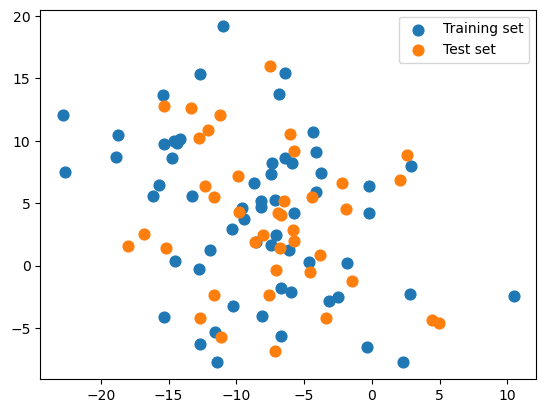

In [77]:
from sklearn.datasets import make_blobs, make_classification

# make synthetic data
X, y = make_blobs(n_samples=100, centers=3, random_state=12, cluster_std=5)
# split it into training and test sets
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(
    X, y, random_state=5, test_size=0.4)

plt.scatter(X_train_toy[:, 0], X_train_toy[:, 1], label="Training set", s=60)
plt.scatter(
    X_test_toy[:, 0], X_test_toy[:, 1], label="Test set", s=60
)
plt.legend(loc="upper right");

Let's transform the data using `StandardScaler` and examine how the data looks like. 

In [78]:
scaler = StandardScaler()
train_transformed = scaler.fit_transform(X_train_toy)
test_transformed = scaler.transform(X_test_toy)

In [79]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std()

(-8.600287211119548, 6.270246946519936)

In [80]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std()

(4.124686209266641, 6.2749592279985595)

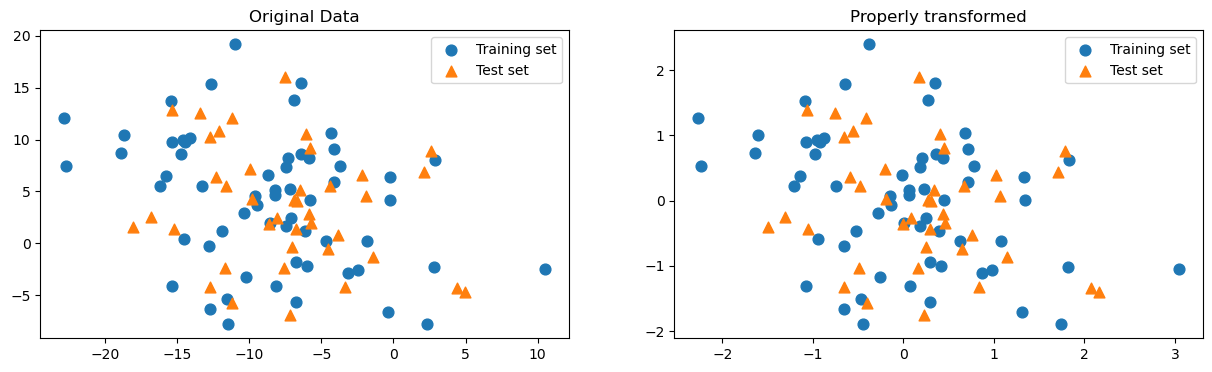

In [81]:
plot_original_scaled(X_train_toy, X_test_toy, train_transformed, test_transformed)

In [82]:
knn = KNeighborsClassifier()
knn.fit(train_transformed, y_train_toy)
print(f"Training score: {knn.score(train_transformed, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_transformed, y_test_toy):.2f}")

Training score: 0.63
Test score: 0.55


<br><br>

#### Bad methodology 1: Scaling the data separately (for class discussion)

In [83]:
# DO NOT DO THIS! For illustration purposes only.
scaler = StandardScaler()
scaler.fit(X_train_toy)
train_scaled = scaler.transform(X_train_toy)

scaler = StandardScaler()  # Creating a separate object for scaling test data
scaler.fit(X_test_toy)  # Calling fit on the test data
test_scaled = scaler.transform(
    X_test_toy
)  # Transforming the test data using the scaler fit on test data

knn = KNeighborsClassifier()
knn.fit(train_scaled, y_train_toy)
print(f"Training score: {knn.score(train_scaled, y_train_toy):.2f}")
print(f"Test score: {knn.score(test_scaled, y_test_toy):.2f}")

Training score: 0.63
Test score: 0.60


- Is anything wrong in methodology 1? If yes, what is it?  

<br><br><br><br>

- What are the mean and standard deviation of columns in `X_train_toy` and `X_test_toy`? 

In [84]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

(-8.600287211119548, 6.270246946519936)

In [85]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(4.124686209266641, 6.2749592279985595)

What are the mean and standard deviation of columns in `X_test_toy`?  

In [86]:
X_test_toy[:, 0].mean(), X_test_toy[:, 0].std() # mean and std of column 1 in X_test_toy

(-7.4360796317881865, 5.415791218175097)

In [87]:
X_test_toy[:, 1].mean(), X_test_toy[:, 1].std() # mean and std of column 2 in X_train_toy

(3.584450392629585, 5.5947435906433025)

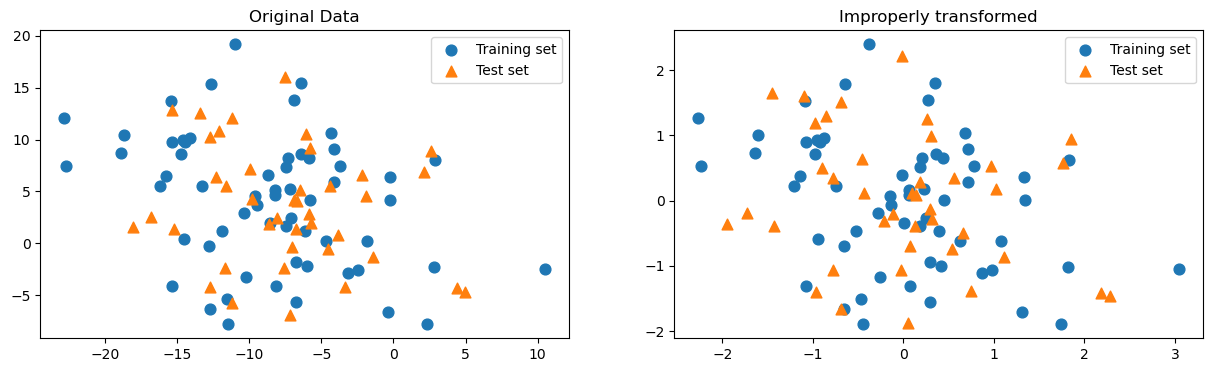

In [88]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    train_scaled,
    test_scaled,
    title_transformed="Improperly transformed",
)

<br><br>

#### Bad methodology 2: Scaling the data together (for class discussion)

In [89]:
X_train_toy.shape, X_test_toy.shape

((60, 2), (40, 2))

In [90]:
# join the train and test sets back together
XX = np.vstack((X_train_toy, X_test_toy))
XX.shape

(100, 2)

In [91]:
scaler = StandardScaler()
scaler.fit(XX)
XX_scaled = scaler.transform(XX)
XX_train = XX_scaled[:X_train_toy.shape[0]]
XX_test = XX_scaled[X_train_toy.shape[0]:]

In [92]:
knn = KNeighborsClassifier()
knn.fit(XX_train, y_train_toy)
print(f"Training score: {knn.score(XX_train, y_train_toy):.2f}")  # Misleading score
print(f"Test score: {knn.score(XX_test, y_test_toy):.2f}")  # Misleading score

Training score: 0.63
Test score: 0.55


- Is anything wrong in methodology 2? If yes, what is it? 
- What's are the mean and std of `X_train_toy` vs. `XX`?

In [ ]:
X_train_toy[:, 0].mean(), X_train_toy[:, 0].std() # mean and std of column 1 in X_train_toy

In [ ]:
X_train_toy[:, 1].mean(), X_train_toy[:, 1].std() # mean and std of column 2 in X_train_toy

What are the mean and standard deviation of columns in `XX`?  

In [ ]:
XX[:, 0].mean(), XX[:, 0].std() # mean and std of column 1 in XX

In [ ]:
XX[:, 1].mean(), XX[:, 1].std() # mean and std of column 2 in XX

There is no big difference but they are not the same. 

In [ ]:
plot_original_scaled(
    X_train_toy,
    X_test_toy,
    XX_train,
    XX_test,
    title_transformed="Improperly transformed",
)

Not a noticeable difference in the transformed data and in scores in this case. But there is information leakage which is not good.   

## ❓❓ Questions for you

### Exercise 3.3

**Select all of the following statements which are TRUE.**

- (A) You can have scaling of numeric features, one-hot encoding of categorical features, and `scikit-learn` estimator within a single pipeline.  
- (B) Once you have a `scikit-learn` pipeline object with an estimator as the last step, you can call `fit`, `predict`, and `score` on it.
- (C) You can carry out data splitting within `scikit-learn` pipeline. 
- (D) We have to be careful of the order we put each transformation and model in a pipeline.
- (E) If you call `cross_validate` with a pipeline object, it will call `fit` and `transform` on the training fold and only `transform` on the validation fold. 


<br><br>

## ❓❓ Questions for you 

### Exercise 4.2

**Select all of the following statements which are TRUE.**

- (A) You could carry out cross-validation by passing a `ColumnTransformer` object to `cross_validate`. 
- (B) After applying column transformer, the order of the columns in the transformed data has to be the same as the order of the columns in the original data. 
- (C) After applying a column transformer, the transformed data is always going to be of different shape than the original data. 
- (D) When you call `fit_transform` on a `ColumnTransformer` object, you get a numpy ndarray. 

<br><br><br><br>